<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  

[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  

Neural Information Processing Systems (NeurIPS), 2019.



- Last updated Date: April 24th 2020

- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/real-dataset/test_data.parquet
/kaggle/input/real-dataset/train_data.parquet


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import json
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.metrics import AUC
from matplotlib.ticker import FuncFormatter

In [4]:
# Setup GPU
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    print('Using GPU')
    
    for i in range(len(gpu_devices)):
        tf.config.experimental.set_memory_growth(gpu_devices[i], True) # Allocated only one GPU memory for this training
else:
    print('Using CPU')

Using CPU


## Experiment path

In [5]:
results_path = Path('time_gan')  #instantiates a concrete path for the platform the code is running on.
if not results_path.exists():
    results_path.mkdir()

In [6]:
experiment = 0

In [7]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

## Normalize Data

In [8]:
table = pq.read_table('../input/real-dataset/train_data.parquet').to_pandas()
table = table.drop(columns=['sample_id', 'time_step'])

tickers = table.columns
df = table.to_numpy()
tickers

Index(['GFAP', 'UCHL1', 'age', 'education', 'gose', 'hypoglycemia',
       'marshall_grade', 'pupil_reactivity', 'severity', 'sex'],
      dtype='object')

In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df).astype(np.float32) # Scale data
print("Data scaled successfully. Shape:", scaled_data.shape)


Data scaled successfully. Shape: (1400, 10)


## Create rolling window sequences

In [10]:
seq_len = 50  # Sliding window
n_seq = 10    # Number of features
batch_size = 32  # You can change this

In [11]:
# Group the dataset

data = []

# for i in range(0, len(df), seq_len):
for i in range(len(df) - seq_len):
    data.append(scaled_data[i : i + seq_len])

n_windows = len(data)

# data = []
# for i in range(0, len(df) - seq_len + 1, seq_len):  # Sliding window approach
#     data.append(scaled_data[i:i + seq_len])
# print(f"Number of sequences created: {len(data)}")


## Create tf.data.Dataset

In [12]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))              # Slices, shuffles (based on window size) and puts the data in batches (based on batch size)

real_series_iter = iter(real_series.repeat())

## Set up random series generator

In [13]:
# Generate random data from uniform distribution

def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [14]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

##  Network Parameters

In [15]:
hidden_dim = 48  # You can change this
num_layers = 3  # You can change this
train_steps = 1000  # Change this
gamma = 1 
dropout=0.2

In [16]:
# Defining Functions and variable

# Create a basic RNN cell
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           kernel_regularizer=l2(0.01),
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

# def make_rnn(n_layers, hidden_units, output_units, name):
#     return Sequential([LSTM(units=hidden_units,
#                            return_sequences=True,
#                            kernel_regularizer=l2(0.01),
#                            name=f'GRU_{i + 1}') for i in range(n_layers)] +
#                       [Dense(units=output_units,
#                              activation='sigmoid',
#                              name='OUT')], name=name)

# Create model for each function
embedder = make_rnn(n_layers=num_layers, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')

recovery = make_rnn(n_layers=num_layers, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

generator = make_rnn(n_layers=num_layers, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')

discriminator = make_rnn(n_layers=num_layers, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')

supervisor = make_rnn(n_layers=num_layers - 1, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# Loss functions
mse = MeanSquaredError()     # Computes the mean of squares of errors between labels and predictions.
bce = BinaryCrossentropy()   # Computes the cross-entropy loss between true labels and predicted labels.


# Calculate generator loss
def get_generator_moment_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])

    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))

    return g_loss_mean + g_loss_var
    
# Extract test data
def get_real_data():
    table = pq.read_table('../input/real-dataset/test_data.parquet').to_pandas()
    table = table.drop(columns=['sample_id', 'time_step'])

    df = np.array(table)
    df = df[np.argsort(df[:, 0])]

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    #for i in range(0, len(df), seq_len):
    for i in range(len(df) - seq_len):
        data.append(scaled_data[i:i + seq_len])

    return data

# Design model for classification task
def get_model():
    model = Sequential([GRU(hidden_dim, input_shape=(seq_len-1, n_seq)),
                        Dense(n_seq)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))

    return model


Running model for time step 1

Training autoencoder


100%|██████████| 1000/1000 [01:54<00:00,  8.73it/s]



Training supervisor


100%|██████████| 1000/1000 [01:09<00:00, 14.39it/s]



Start Joint Training
     0 | d_loss: 2.1778 | g_loss_u: 0.6113 | g_loss_s: 0.0013 | g_loss_v: 0.5068 | e_loss_t0: 0.0410
   100 | d_loss: 1.1243 | g_loss_u: 2.1203 | g_loss_s: 0.0003 | g_loss_v: 0.0936 | e_loss_t0: 0.0192
   200 | d_loss: 0.9178 | g_loss_u: 2.0641 | g_loss_s: 0.0006 | g_loss_v: 0.1019 | e_loss_t0: 0.0124
   300 | d_loss: 1.1731 | g_loss_u: 3.3199 | g_loss_s: 0.0006 | g_loss_v: 0.0871 | e_loss_t0: 0.0144
   400 | d_loss: 1.6463 | g_loss_u: 1.2634 | g_loss_s: 0.0009 | g_loss_v: 0.0972 | e_loss_t0: 0.0120
   500 | d_loss: 0.6340 | g_loss_u: 1.9116 | g_loss_s: 0.0007 | g_loss_v: 0.1036 | e_loss_t0: 0.0171
   600 | d_loss: 1.0000 | g_loss_u: 1.5989 | g_loss_s: 0.0005 | g_loss_v: 0.0738 | e_loss_t0: 0.0103
   700 | d_loss: 0.7657 | g_loss_u: 1.4994 | g_loss_s: 0.0007 | g_loss_v: 0.0796 | e_loss_t0: 0.0098
   800 | d_loss: 1.7639 | g_loss_u: 2.9460 | g_loss_s: 0.0007 | g_loss_v: 0.1145 | e_loss_t0: 0.0085
   900 | d_loss: 1.0875 | g_loss_u: 2.7944 | g_loss_s: 0.0166 | g_los

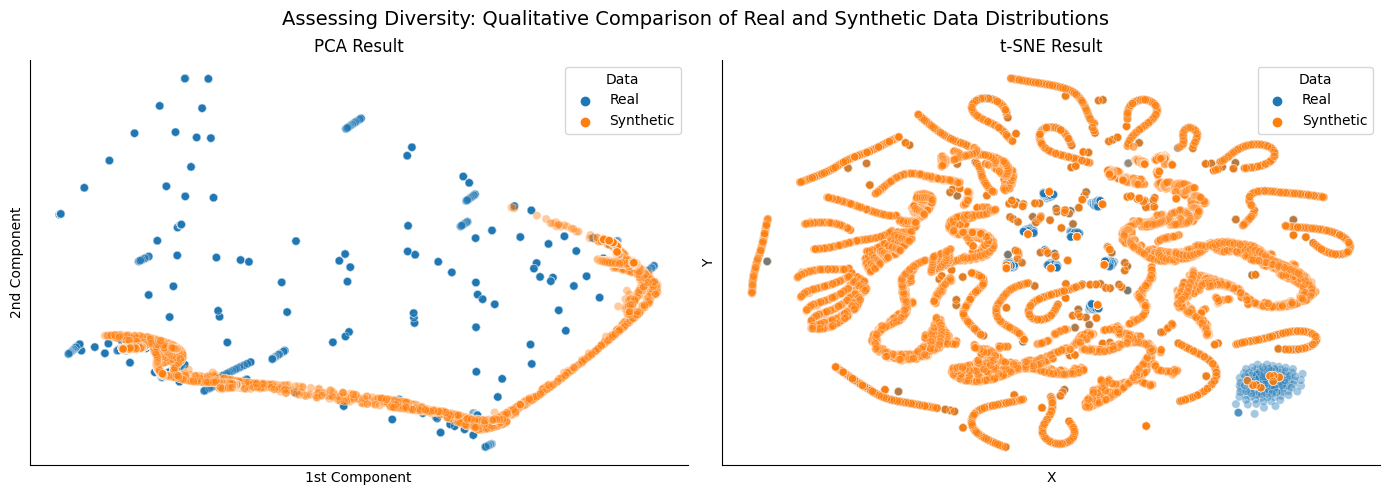


Starting data fidelity
5/5 - 0s - 13ms/step - AUC: 1.0000 - accuracy: 1.0000 - loss: 3.7273e-04
Discriminative score:  0.5


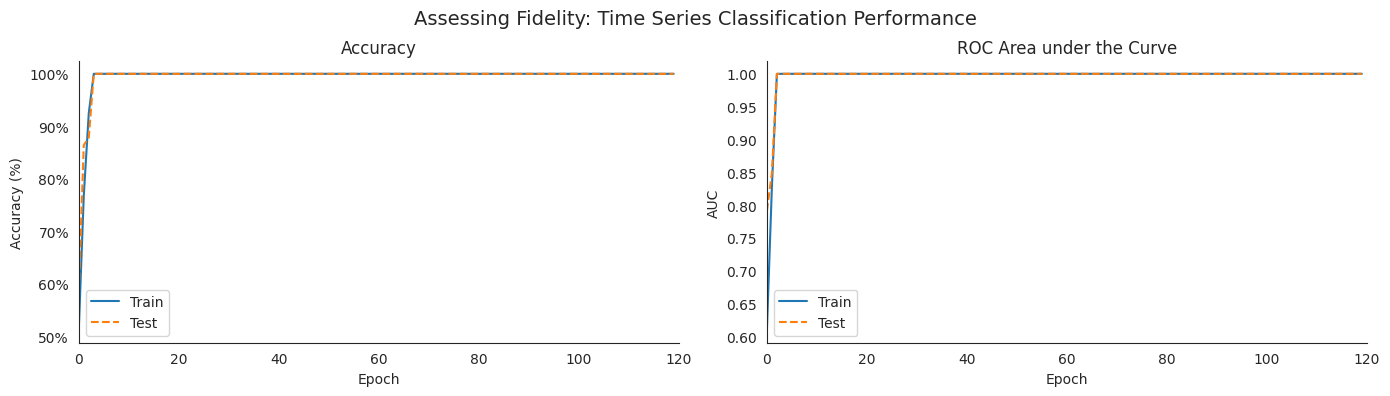


Starting TSTR
TSTR Error:  0.36310838627815245
TRTR Error:  0.20389210146665573


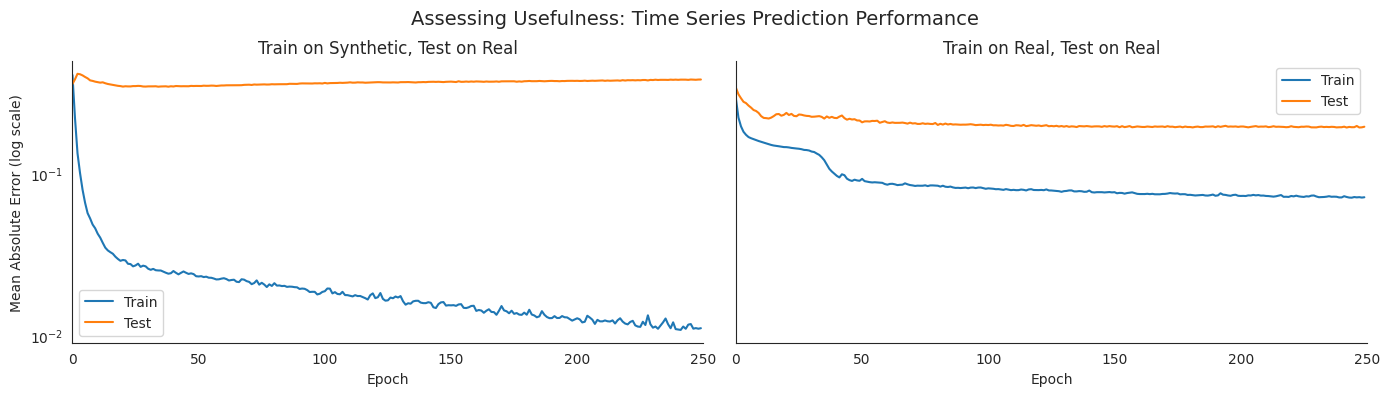

In [17]:
# Run TimeGAN for several times while simultaneously changing model parameters

num_of_runs = 1
# Change this
all_metric = []

writer = tf.summary.create_file_writer(log_dir.as_posix())   # Creates a summary file writer for the given log directory and puts it in the created path above

for time in range(1, num_of_runs + 1):
    print(f"\nRunning model for time step {time}")

    output_dir = f'results{time}'
    os.makedirs(output_dir, exist_ok=True)

    parameters = {"hidden_dim":hidden_dim, "num_layers":num_layers, "epochs":train_steps, "seq_len":seq_len, "batch_size":batch_size}
    with open(f"{output_dir}/parameters{time}.json", "w") as f:
        json.dump(parameters, f, indent=4)

    X = Input(shape=[seq_len, n_seq], name='RealData')      # Placeholder for the real data
    Z = Input(shape=[seq_len, n_seq], name='RandomData')    # Placeholder for the randomly generated data

    # Autoencoder
    H = embedder(X)          # Creates latent space for the real data
    X_tilde = recovery(H)    # Recreates real data for above latent space

    autoencoder = Model(inputs=X, outputs=X_tilde, name='Autoencoder')
    autoencoder_optimizer = Adam()

    
    print("\nTraining autoencoder")
    @tf.function
    def train_autoencoder_init(x):
        with tf.GradientTape() as tape:      # Record operations for automatic differentiation
            x_tilde = autoencoder(x)
            embedding_loss_t0 = mse(x, x_tilde)
            e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)    # Scaling the loss so that the model can notice the variations

        var_list = embedder.trainable_variables + recovery.trainable_variables
        gradients = tape.gradient(e_loss_0, var_list)
        autoencoder_optimizer.apply_gradients(zip(gradients, var_list))

        return tf.sqrt(embedding_loss_t0)

    # Train step
    for step in tqdm(range(train_steps)):
        X_ = next(real_series_iter)
        step_e_loss_t0 = train_autoencoder_init(X_)
        with writer.as_default():
            tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

    # save autoencoder model
    autoencoder.save(f'{output_dir}/autoencoder{time}.h5')

        
    # Supervisor
    E_hat = generator(Z)     # Creates latent space for fake data
    H_hat = supervisor(E_hat)     # Creates estimated next Y sequence (for fake data)
    Y_fake = discriminator(H_hat)     # Outputs the estimated next Y classification (for fake data)
    
    adversarial_supervised = Model(inputs=Z, outputs=Y_fake, name='AdversarialNetSupervised') 
    supervisor_optimizer = Adam()

    print("\nTraining supervisor")
    @tf.function
    def train_supervisor(x):
        with tf.GradientTape() as tape:
            h = embedder(x)        # Computes real data latent space
            h_hat_supervised = supervisor(h)     # Computes estimated next sequence (for real data)
            g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])    # Computes loss between actual next sequence and estimated next sequence (for real data)

        var_list = supervisor.trainable_variables
        gradients = tape.gradient(g_loss_s, var_list)
        supervisor_optimizer.apply_gradients(zip(gradients, var_list))

        return g_loss_s

    # Train step
    for step in tqdm(range(train_steps)):
        X_ = next(real_series_iter)
        step_g_loss_s = train_supervisor(X_)
        with writer.as_default():
            tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

    # Save model
    supervisor.save(f'{output_dir}/supervisor{time}.h5')

    
    # Joint training
    generator_optimizer = Adam()
    discriminator_optimizer = Adam()
    embedding_optimizer = Adam()

    # Adversarial
    Y_fake_e = discriminator(E_hat)     # Outputs the next Y classification (for fake data)
    adversarial_emb = Model(inputs=Z, outputs=Y_fake_e, name='AdversarialNet')

    X_hat = recovery(H_hat)     # Outputs the next fake x data
    synthetic_data_model = Model(inputs=Z, outputs=X_hat, name='SyntheticData')

    Y_real = discriminator(H)     # Outputs classification of the real data
    discriminator_model = Model(inputs=X, outputs=Y_real, name='DiscriminatorReal')


    @tf.function
    def train_generator(x, z):
        with tf.GradientTape() as tape:
            y_fake = adversarial_supervised(z)     # Outputs the estimated next Y classification (for fake data)
            generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake), y_pred=y_fake)

            y_fake_e = adversarial_emb(z)     # Outputs the next Y classification (for fake data)
            generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),  y_pred=y_fake_e)

            h = embedder(x)
            h_hat_supervised = supervisor(h)
            generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_hat = synthetic_data_model(z)     # Outputs the next fake x data
            generator_moment_loss = get_generator_moment_loss(x, x_hat)

            generator_loss = (generator_loss_unsupervised +
                              generator_loss_unsupervised_e +
                              100 * tf.sqrt(generator_loss_supervised) +
                              100 * generator_moment_loss)

        var_list = generator.trainable_variables + supervisor.trainable_variables
        gradients = tape.gradient(generator_loss, var_list)
        generator_optimizer.apply_gradients(zip(gradients, var_list))
        return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss


    @tf.function
    def train_embedder(x):
        with tf.GradientTape() as tape:
            h = embedder(x)
            h_hat_supervised = supervisor(h)
            generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_tilde = autoencoder(x) # Recovered real X
            embedding_loss_t0 = mse(x, x_tilde)
            e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

        var_list = embedder.trainable_variables + recovery.trainable_variables
        gradients = tape.gradient(e_loss, var_list)
        embedding_optimizer.apply_gradients(zip(gradients, var_list))

        return tf.sqrt(embedding_loss_t0)


    @tf.function
    def get_discriminator_loss(x, z):
        y_real = discriminator_model(x)     # Outputs classification of the real data
        discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                      y_pred=y_real)

        y_fake = adversarial_supervised(z)     # Outputs the estimated next Y classification (for fake data)
        discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                      y_pred=y_fake)

        y_fake_e = adversarial_emb(z)     # Outputs the next Y classification (for fake data)
        discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                        y_pred=y_fake_e)

        return (discriminator_loss_real +
                discriminator_loss_fake +
                gamma * discriminator_loss_fake_e)


    @tf.function
    def train_discriminator(x, z):
        with tf.GradientTape() as tape:
            discriminator_loss = get_discriminator_loss(x, z)

        var_list = discriminator.trainable_variables
        gradients = tape.gradient(discriminator_loss, var_list)
        discriminator_optimizer.apply_gradients(zip(gradients, var_list))

        return discriminator_loss
    
#         print("\nStart Joint Training")
#         generator_loss = []
# discriminator_loss = []

# for epoch in range(epochs):
#     # Train generator more frequently than discriminator
#     for _ in range(2):  # Adjust frequency as needed
#         X_ = next(real_series_iter)
#         Z_ = next(random_series)

#         # Train generator
#         g_loss_u, g_loss_s, g_loss_v = train_generator(X_, Z_)
#         generator_loss.append(g_loss_u + g_loss_s + g_loss_v)

#     # Train discriminator
#     X_ = next(real_series_iter)
#     Z_ = next(random_series)
#     d_loss = train_discriminator(X_, Z_)
#     discriminator_loss.append(d_loss)

#     # Print progress and visualize losses every 100 epochs
#     if epoch % 100 == 0:
#         print(f"Epoch {epoch}: Generator Loss = {g_loss_u + g_loss_s + g_loss_v}, Discriminator Loss = {d_loss}")
#         plot_losses(generator_loss, discriminator_loss)


    
    print("\nStart Joint Training")
    # Group training
    step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
    for step in range(train_steps):
        # Train generator (twice as often as discriminator)
        for kk in range(5):
            X_ = next(real_series_iter)
            Z_ = next(random_series)

            # Train generator
            step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
            # Train embedder
            step_e_loss_t0 = train_embedder(X_)

        X_ = next(real_series_iter)
        Z_ = next(random_series)
        step_d_loss = get_discriminator_loss(X_, Z_)

        if step_d_loss > 0.15:
            step_d_loss = train_discriminator(X_, Z_)

        if step % 100 == 0:
            print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
                  f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

        with writer.as_default():
            tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
            tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
            tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
            tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
            tf.summary.scalar('D Loss', step_d_loss, step=step)

    # Save model
    synthetic_data_model.save(f'{output_dir}/synthetic_data_model{time}.h5')

    print("Joint training ended.")

        
    # Generate synthetic data
    print('\nGenerating synthetic data.')

    generated_data = []
    
    for i in range(n_windows):
        Z_ = next(random_series)
        d = synthetic_data_model(Z_)
        generated_data.append(d)

    generated_data = np.array(np.vstack(generated_data))
    np.save(f'{output_dir}/generated_data{time}.npy', generated_data)

    # Export synthetic data
    generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))
    gen_data = pd.DataFrame(generated_data.reshape(-1, n_seq), columns=tickers)
    gen_data.to_csv(f'{output_dir}/synthetic_data{time}.csv', index=False)

    print("\nSynthetic data generated!")

        
    # Evaluating synthetic data
    real_data = data
    
    synthetic_data = np.load(f'{output_dir}/generated_data{time}.npy')
    print("Synthetic data shape (Before): ", synthetic_data.shape)
    real_data = np.asarray(real_data)
    print("Real data shape: ", real_data.shape)
    synthetic_data = synthetic_data[:real_data.shape[0]]
    print("Synthetic data shape (After): ", synthetic_data.shape)

    # Prepare sample
    sample_size = len(real_data)
    idx = np.random.permutation(len(real_data))[:sample_size]
        
    # Data preprocessing
    real_sample = np.asarray(real_data)[idx]
    synthetic_sample = np.asarray(synthetic_data)[idx]

    real_sample_2d = real_sample.reshape(-1, seq_len)
    synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

        
    # Visualization
    print("\nStarting Visualization")

    ## PCA
    pca = PCA(n_components=2)
    pca.fit(real_sample_2d)

    pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
                    .assign(Data='Real'))
    pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                         .assign(Data='Synthetic'))

    pca_result = pd.concat([pca_real, pca_synthetic]).rename(columns={0: '1st Component', 1: '2nd Component'})

    ## t-SNE
    tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

    tsne = TSNE(n_components=2,
                    verbose=1,
                    perplexity=40)

    tsne_result = tsne.fit_transform(tsne_data)
    tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
    tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

    # Plot visual
    fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
    sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                        hue='Data', ax=axes[0], alpha=0.4)
    sns.despine()
    axes[0].set_title('PCA Result')

    sns.scatterplot(x='X', y='Y',
                        data=tsne_result,
                        hue='Data', 
                        ax=axes[1], alpha=0.4)
    sns.despine()

    for i in [0, 1]:
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    axes[1].set_title('t-SNE Result')
    fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
                     fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.88);

    # Save image
    fig.savefig(f'{output_dir}/visualization{time}.svg')
    plt.show()

        
    # Data fidelity
    print("\nStarting data fidelity")

    ## Discrimination
    real_data = get_real_data()
    real_data = np.array(real_data)
    synthetic_data = np.array(synthetic_data)[:len(real_data)]

    n_series = real_data.shape[0]
    idx = np.arange(n_series)

    n_train = int(.8*n_series)
    train_idx = idx[:n_train]
    test_idx = idx[n_train:]

    train_data = np.vstack((real_data[train_idx], synthetic_data[train_idx]))
    test_data = np.vstack((real_data[test_idx], synthetic_data[test_idx]))

    n_train, n_test = len(train_idx), len(test_idx)
    train_labels = np.concatenate((np.ones(n_train), np.zeros(n_train)))
    test_labels = np.concatenate((np.ones(n_test), np.zeros(n_test)))

    # Create classifier
    epoch = 120
    ts_classifier = Sequential([GRU(10, input_shape=(seq_len, n_seq), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

    ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

    result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=epoch,
                           batch_size=24,
                           verbose=0)

    loss, auc, acc = ts_classifier.evaluate(x=test_data, y=test_labels, verbose=2)
    all_metric.append([loss, auc, acc, acc-0.5])
    #print(loss, auc, acc)
    print("Discriminative score: ", acc-0.5)
    
    history = pd.DataFrame(result.history)

    # Plot
    sns.set_style('white')
    fig, axes = plt.subplots(ncols=2, figsize=(14,4))
    history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                             title='ROC Area under the Curve',
                                                                                            style=['-', '--'],
                                                                                            xlim=(0, epoch))

    history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                                 title='Accuracy',
                                                                                                                style=['-', '--'],
                                                                                                                xlim=(0, epoch))

    for i in [0, 1]:
        axes[i].set_xlabel('Epoch')

    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    axes[0].set_ylabel('Accuracy (%)')
    axes[1].set_ylabel('AUC')
    sns.despine()

    fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.85);

    # save plots
    fig.savefig(f'{output_dir}/fidelity{time}.svg')
    plt.show()

        
    # TSTR
    print("\nStarting TSTR")

    ## Predictive
    real_data = get_real_data()
    real_data = np.array(real_data)
    synthetic_data = np.array(synthetic_data)[:len(real_data)]

    real_train_data = real_data[train_idx, :n_seq - 1, :]
    real_train_label = real_data[train_idx, -1, :]

    real_test_data = real_data[test_idx, :n_seq - 1, :]
    real_test_label = real_data[test_idx, -1, :]

    synthetic_train = synthetic_data[:, :n_seq - 1, :]
    synthetic_label = synthetic_data[:, -1, :]

    # Call classifier model
    epoch = 250
    ts_regression = get_model()

    synthetic_result = ts_regression.fit(x=synthetic_train,
                                             y=synthetic_label,
                                             validation_data=(
                                                 real_test_data, 
                                                 real_test_label),
                                             epochs=epoch,
                                             batch_size=24,
                                             verbose=0)

    ts_regression = get_model()
    real_result = ts_regression.fit(x=real_train_data,
                                        y=real_train_label,
                                        validation_data=(
                                            real_test_data, 
                                            real_test_label),
                                        epochs=epoch,
                                        batch_size=24,
                                        verbose=0)

    synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
    real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

    print("TSTR Error: ", synthetic_result['Test'].mean())
    print("TRTR Error: ", real_result['Test'].mean())

    all_metric.append([synthetic_result['Test'].mean(), real_result['Test'].mean()])

    # Plot
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
    synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, epoch))
    real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, epoch))

    for i in [0, 1]:
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Mean Absolute Error (log scale)')

    sns.despine()
    fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.85);

    # save plot
    fig.savefig(f'{output_dir}/TSTR{time}.svg')
    plt.show()

    
    # Clear session
    tf.keras.backend.clear_session(free_memory=True)


    # Update parameters
    train_steps += 100  # You can change this

In [18]:
# Export metrics

with open("evaluation_results.json", "w") as file:
    json.dump(all_metric, file, indent=4)

In [19]:
#!rm -rf /kaggle/working/*

###### 